In [ ]:
## Import necessary libraries here (You can add libraries you want to use here)
from skimage.util import img_as_float
from skimage import io, color
from skimage import draw
import matplotlib.pyplot as plt
import argparse, time
import math, copy
import numpy as np
import scipy.io
import cv2
from PIL import Image, ImageDraw
from google.colab.patches import cv2_imshow

In [ ]:
def show_image(img, scale=1.0):
    plt.figure(figsize=scale* plt.figaspect(1))
    plt.imshow(img, interpolation='nearest')
    plt.gray()
    plt.axis('off')
    plt.show()



# Part 1: SLIC Superpixels

## Overview

Superpixel algorithms group pixels into perceptually meaningful regions while respecting potential object contours, and thereby can replace the rigid pixel grid structure. Due to the reduced complexity, superpixels are becoming popular for various computer vision applications, e.g., multiclass object segmentation, depth estimation, human pose estimation, and object localization.

In this problem,we implemented a simple superpixel algorithm called Simple Linear Iterative Clustering (SLIC) that clusters pixels in the five-dimensional color and pixel coordinate space (e.g., r, g, b, x, y). The algorithm starts with a collection of K cluster centers initialized at an equally sampled regular grid on the image of N pixels. For each cluster, you define for a localized window 2S x 2S centered at the cluster center, where S = sqrt(N/K) is the roughly the space between the seed cluster centers. Then, you check whether the pixel within the 2S x 2S local window should be assigned to the cluster center or not (by comparing the distance in 5D space to the cluster center). Once you loop through all the clusters, you can update the cluster center by averaging over the cluster members. Iterate the pixel-to-cluster assignment process till convergence or maximum iterations reached.

Reference Paper: http://www.kev-smith.com/papers/SMITH_TPAMI12.pdf

You can refer to the following slide covered in Lecture_17_Segmentation.pptx here: https://drive.google.com/file/d/1bRmNBXgK1_kWcY-nhw_As5fP10aRhuDC/view?usp=share_link






## Data
**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [ ]:
# Download Data -- run this cell only one time per runtime
!gdown 1jbg2VMZ9yAJMHQNRCTgqZM1PyQRtcPyV
!unzip "/content/Part1_SLIC.zip" -d "/content/"

Downloading...
From: https://drive.google.com/uc?id=1jbg2VMZ9yAJMHQNRCTgqZM1PyQRtcPyV
To: /content/Part1_SLIC.zip
100% 6.19M/6.19M [00:00<00:00, 111MB/s]
Archive:  /content/Part1_SLIC.zip
replace /content/Part1_SLIC/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/Part1_SLIC/.DS_Store  
  inflating: /content/__MACOSX/Part1_SLIC/._.DS_Store  
  inflating: /content/Part1_SLIC/sample_data/.DS_Store  
  inflating: /content/__MACOSX/Part1_SLIC/sample_data/._.DS_Store  
  inflating: /content/__MACOSX/Part1_SLIC/sample_data/._images  
  inflating: /content/__MACOSX/Part1_SLIC/sample_data/._groundTruth  
  inflating: /content/Part1_SLIC/BSD_data/.DS_Store  
  inflating: /content/__MACOSX/Part1_SLIC/BSD_data/._.DS_Store  
  inflating: /content/__MACOSX/Part1_SLIC/BSD_data/._groundTruth  
  inflating: /content/Part1_SLIC/sample_data/images/5096.jpg  
  inflating: /content/__MACOSX/Part1_SLIC/sample_data/images/._5096.jpg  
  inflating: /content/Part1_SLIC/sample_data/imag

## Helper Functions:

100%|██████████| 4/4 [00:05<00:00,  1.28s/it]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:111: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Final Segmented Image


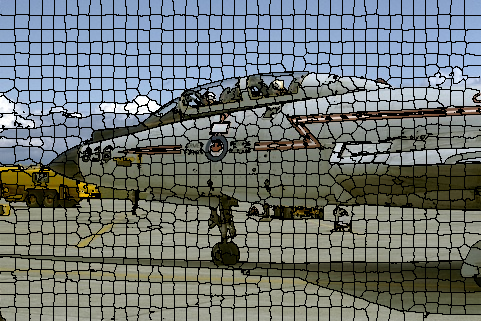

True

In [ ]:

import numpy
import sys
import cv2
import tqdm

def generate_pixels():
    indnp = numpy.mgrid[0:SLIC_height,0:SLIC_width].swapaxes(0,2).swapaxes(0,1)
    for i in tqdm.tqdm(range(SLIC_ITERATIONS)):
        SLIC_distances = 1 * numpy.ones(img.shape[:2])
        for j in range(SLIC_centers.shape[0]):
            x_low, x_high = int(SLIC_centers[j][3] - step), int(SLIC_centers[j][3] + step)
            y_low, y_high = int(SLIC_centers[j][4] - step), int(SLIC_centers[j][4] + step)

            if x_low <= 0:
                x_low = 0
            #end
            if x_high > SLIC_width:
                x_high = SLIC_width
            #end
            if y_low <=0:
                y_low = 0
            #end
            if y_high > SLIC_height:
                y_high = SLIC_height
            #end

            cropimg = SLIC_labimg[y_low : y_high , x_low : x_high]
            color_diff = cropimg - SLIC_labimg[int(SLIC_centers[j][4]), int(SLIC_centers[j][3])]
            color_distance = numpy.sqrt(numpy.sum(numpy.square(color_diff), axis=2))

            yy, xx = numpy.ogrid[y_low : y_high, x_low : x_high]
            pixdist = ((yy-SLIC_centers[j][4])**2 + (xx-SLIC_centers[j][3])**2)**0.5

            # SLIC_m is "m" in the paper, (m/S)*dxy
            dist = ((color_distance/SLIC_m)**2 + (pixdist/step)**2)**0.5

            distance_crop = SLIC_distances[y_low : y_high, x_low : x_high]
            idx = dist < distance_crop
            distance_crop[idx] = dist[idx]
            SLIC_distances[y_low : y_high, x_low : x_high] = distance_crop
            SLIC_clusters[y_low : y_high, x_low : x_high][idx] = j
        #end

        for k in range(len(SLIC_centers)):
            #k=256
            idx = (SLIC_clusters == k)
            colornp = SLIC_labimg[idx]
            distnp = indnp[idx]
            SLIC_centers[k][0:3] = numpy.sum(colornp, axis=0)
            sumy, sumx = numpy.sum(distnp, axis=0)
            SLIC_centers[k][3:] = sumx, sumy
            SLIC_centers[k] /= numpy.sum(idx)

def create_connectivity():
    label = 0
    adj_label = 0
    lims = int(SLIC_width * SLIC_height / SLIC_centers.shape[0])

    new_clusters = -1 * numpy.ones(img.shape[:2]).astype(numpy.int64)
    elements = []
    for i in range(SLIC_width):
        for j in range(SLIC_height):
            if new_clusters[j, i] == -1:
                elements = []
                elements.append((j, i))
                for dx, dy in [(-1,0), (0,-1), (1,0), (0,1)]:
                    x = elements[0][1] + dx
                    y = elements[0][0] + dy
                    if (x>=0 and x < SLIC_width and
                        y>=0 and y < SLIC_height and
                        new_clusters[y, x] >=0):
                        adj_label = new_clusters[y, x]
                    #end
                #end
            #end

            count = 1
            counter = 0
            while counter < count:
                for dx, dy in [(-1,0), (0,-1), (1,0), (0,1)]:
                    x = elements[counter][1] + dx
                    y = elements[counter][0] + dy

                    if (x>=0 and x<SLIC_width and y>=0 and y<SLIC_height):
                        if new_clusters[y, x] == -1 and SLIC_clusters[j, i] == SLIC_clusters[y, x]:
                            elements.append((y, x))
                            new_clusters[y, x] = label
                            count+=1
                        #end
                    #end
                #end

                counter+=1
            #end
            if (count <= lims >> 2):
                for counter in range(count):
                    new_clusters[elements[counter]] = adj_label
                #end

                label-=1
            #end

            label+=1
        #end
    #end

    SLIC_new_clusters = new_clusters
#end

def display_contours(color):
    is_taken = numpy.zeros(img.shape[:2], numpy.bool)
    contours = []

    for i in range(SLIC_width):
        for j in range(SLIC_height):
            nr_p = 0
            for dx, dy in [(-1,0), (-1,-1), (0,-1), (1,-1), (1,0), (1,1), (0,1), (-1,1)]:
                x = i + dx
                y = j + dy
                if x>=0 and x < SLIC_width and y>=0 and y < SLIC_height:
                    if is_taken[y, x] == False and SLIC_clusters[j, i] != SLIC_clusters[y, x]:
                        nr_p += 1
                    #end
                #end
            #end

            if nr_p >= 2:
                is_taken[j, i] = True
                contours.append([j, i])
            #end
        #end
    #end
    for i in range(len(contours)):
        img[contours[i][0], contours[i][1]] = color
    #end
#end

def find_local_minimum(center):
    min_grad = 1
    loc_min = center
    for i in range(center[0] - 1, center[0] + 2):
        for j in range(center[1] - 1, center[1] + 2):
            c1 = SLIC_labimg[j+1, i]
            c2 = SLIC_labimg[j, i+1]
            c3 = SLIC_labimg[j, i]
            if ((c1[0] - c3[0])**2)**0.5 + ((c2[0] - c3[0])**2)**0.5 < min_grad:
                min_grad = abs(c1[0] - c3[0]) + abs(c2[0] - c3[0])
                loc_min = [i, j]
            #end
        #end
    #end
    return loc_min
#end

def calculate_centers():
    centers = []
    for i in range(step, SLIC_width - int(step/2), step):
        for j in range(step, SLIC_height - int(step/2), step):
            nc = find_local_minimum(center=(i, j))
            color = SLIC_labimg[nc[1], nc[0]]
            center = [color[0], color[1], color[2], nc[0], nc[1]]
            centers.append(center)
        #end
    #end

    return centers
#end

# global variables
img = cv2.imread('/content/Part1_SLIC/BSD_data/images/10081.jpg')

step = int((img.shape[0]*img.shape[1]/int(1000))**0.5)
SLIC_m = int(40)
SLIC_ITERATIONS = 4
SLIC_height, SLIC_width = img.shape[:2]
SLIC_labimg = cv2.cvtColor(img, cv2.COLOR_BGR2LAB).astype(numpy.float64)
SLIC_distances = 1 * numpy.ones(img.shape[:2])
SLIC_clusters = -1 * SLIC_distances
SLIC_center_counts = numpy.zeros(len(calculate_centers()))
SLIC_centers = numpy.array(calculate_centers())

# main
generate_pixels()
create_connectivity()
calculate_centers()
display_contours([0.0, 0.0, 0.0])
print("Final Segmented Image")
cv2_imshow(img)
cv2.waitKey(0)
cv2.imwrite("SLICimg.jpg", img)

100%|██████████| 4/4 [00:00<00:00,  5.51it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:111: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


For K=128 and first weight m=25


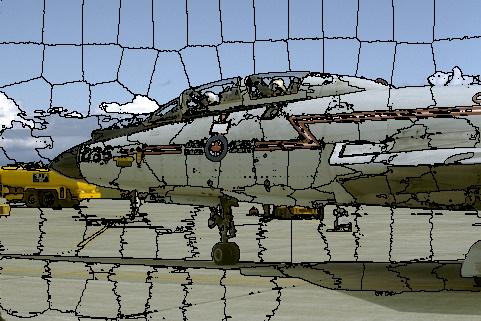

True

In [ ]:
# for K=128 I choose first weight m=25
img = cv2.imread('/content/Part1_SLIC/BSD_data/images/10081.jpg')

step = int((img.shape[0]*img.shape[1]/int(128))**0.5)
SLIC_m = int(25)
SLIC_ITERATIONS = 4
SLIC_height, SLIC_width = img.shape[:2]
SLIC_labimg = cv2.cvtColor(img, cv2.COLOR_BGR2LAB).astype(numpy.float64)
SLIC_distances = 1 * numpy.ones(img.shape[:2])
SLIC_clusters = -1 * SLIC_distances
SLIC_center_counts = numpy.zeros(len(calculate_centers()))
SLIC_centers = numpy.array(calculate_centers())

# main
generate_pixels()
create_connectivity()
calculate_centers()
display_contours([0.0, 0.0, 0.0])
print("For K=128 and first weight m=25")
cv2_imshow(img)
cv2.waitKey(0)
cv2.imwrite("SLICimg.jpg", img)

100%|██████████| 4/4 [00:01<00:00,  2.04it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:111: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


For K=128 I choose 2nd weight m=100


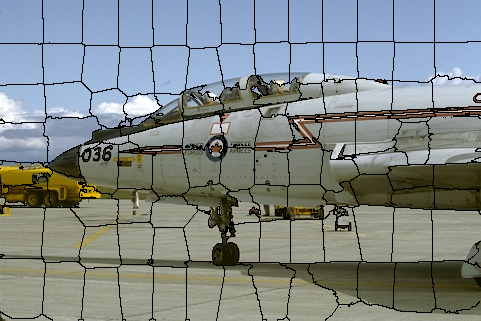

True

In [ ]:
# for K=128 I choose 2nd weight m=100
img = cv2.imread('/content/Part1_SLIC/BSD_data/images/10081.jpg')

step = int((img.shape[0]*img.shape[1]/int(128))**0.5)
SLIC_m = int(100)
SLIC_ITERATIONS = 4
SLIC_height, SLIC_width = img.shape[:2]
SLIC_labimg = cv2.cvtColor(img, cv2.COLOR_BGR2LAB).astype(numpy.float64)
SLIC_distances = 1 * numpy.ones(img.shape[:2])
SLIC_clusters = -1 * SLIC_distances
SLIC_center_counts = numpy.zeros(len(calculate_centers()))
SLIC_centers = numpy.array(calculate_centers())

# main
generate_pixels()
create_connectivity()
calculate_centers()
display_contours([0.0, 0.0, 0.0])
print("For K=128 I choose 2nd weight m=100")
cv2_imshow(img)
cv2.waitKey(0)
cv2.imwrite("SLICimg.jpg", img)

100%|██████████| 4/4 [00:00<00:00,  5.58it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:111: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


For K=128 I choose 3rd weight m=150


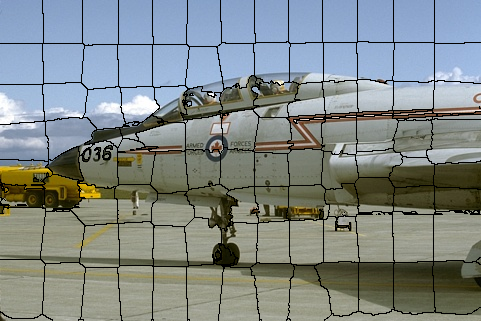

True

In [ ]:
# for K=128 I choose 3rd weight m=150
img = cv2.imread('/content/Part1_SLIC/BSD_data/images/10081.jpg')

step = int((img.shape[0]*img.shape[1]/int(128))**0.5)
SLIC_m = int(150)
SLIC_ITERATIONS = 4
SLIC_height, SLIC_width = img.shape[:2]
SLIC_labimg = cv2.cvtColor(img, cv2.COLOR_BGR2LAB).astype(numpy.float64)
SLIC_distances = 1 * numpy.ones(img.shape[:2])
SLIC_clusters = -1 * SLIC_distances
SLIC_center_counts = numpy.zeros(len(calculate_centers()))
SLIC_centers = numpy.array(calculate_centers())

# main
generate_pixels()
create_connectivity()
calculate_centers()
display_contours([0.0, 0.0, 0.0])
print("For K=128 I choose 3rd weight m=150")
cv2_imshow(img)
cv2.waitKey(0)
cv2.imwrite("SLICimg.jpg", img)

100%|██████████| 4/4 [00:00<00:00,  7.97it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:111: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


For K=64 and  I fixed the weight m=100


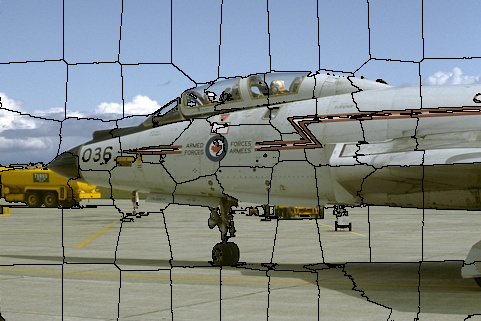

True

In [ ]:
# for K=64 I choose fixed weight m=100
img = cv2.imread('/content/Part1_SLIC/BSD_data/images/10081.jpg')

step = int((img.shape[0]*img.shape[1]/int(64))**0.5)
SLIC_m = int(100)
SLIC_ITERATIONS = 4
SLIC_height, SLIC_width = img.shape[:2]
SLIC_labimg = cv2.cvtColor(img, cv2.COLOR_BGR2LAB).astype(numpy.float64)
SLIC_distances = 1 * numpy.ones(img.shape[:2])
SLIC_clusters = -1 * SLIC_distances
SLIC_center_counts = numpy.zeros(len(calculate_centers()))
SLIC_centers = numpy.array(calculate_centers())

# main
generate_pixels()
create_connectivity()
calculate_centers()
display_contours([0.0, 0.0, 0.0])
print("For K=64 and  I fixed the weight m=100")
cv2_imshow(img)
cv2.waitKey(0)
cv2.imwrite("SLICimg.jpg", img)

100%|██████████| 4/4 [00:01<00:00,  3.07it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:111: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Segmentation result for K=256 with fixed weight m=100


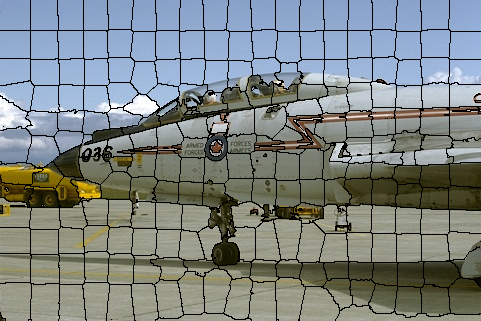

True

In [ ]:
# for K=128 I fixed the weight m=100
img = cv2.imread('/content/Part1_SLIC/BSD_data/images/10081.jpg')

step = int((img.shape[0]*img.shape[1]/int(256))**0.5)
SLIC_m = int(100)
SLIC_ITERATIONS = 4
SLIC_height, SLIC_width = img.shape[:2]
SLIC_labimg = cv2.cvtColor(img, cv2.COLOR_BGR2LAB).astype(numpy.float64)
SLIC_distances = 1 * numpy.ones(img.shape[:2])
SLIC_clusters = -1 * SLIC_distances
SLIC_center_counts = numpy.zeros(len(calculate_centers()))
SLIC_centers = numpy.array(calculate_centers())

# main
generate_pixels()
create_connectivity()
calculate_centers()
display_contours([0.0, 0.0, 0.0])
print("Segmentation result for K=256 with fixed weight m=100")
cv2_imshow(img)
cv2.waitKey(0)
cv2.imwrite("SLICimg.jpg", img)

100%|██████████| 4/4 [00:04<00:00,  1.21s/it]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:111: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 Segmentation Result for K=1024 with fixed weight m=100


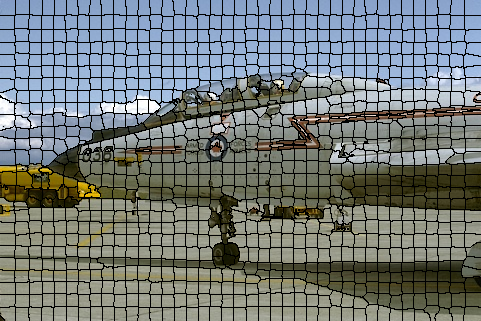

True

In [ ]:
# for K=128, m=100
img = cv2.imread('/content/Part1_SLIC/BSD_data/images/10081.jpg')

step = int((img.shape[0]*img.shape[1]/int(1024))**0.5)
SLIC_m = int(100)
SLIC_ITERATIONS = 4
SLIC_height, SLIC_width = img.shape[:2]
SLIC_labimg = cv2.cvtColor(img, cv2.COLOR_BGR2LAB).astype(numpy.float64)
SLIC_distances = 1 * numpy.ones(img.shape[:2])
SLIC_clusters = -1 * SLIC_distances
SLIC_center_counts = numpy.zeros(len(calculate_centers()))
SLIC_centers = numpy.array(calculate_centers())

# main
generate_pixels()
create_connectivity()
calculate_centers()
display_contours([0.0, 0.0, 0.0])
print(" Segmentation Result for K=1024 with fixed weight m=100")
cv2_imshow(img)
cv2.waitKey(0)
cv2.imwrite("SLICimg.jpg", img)

In [ ]:
# a)

img_path = "/content/Part1_SLIC/BSD_data/images/10081.jpg"

image = img_as_float(io.imread(img_path))

# convert RGB to LAB
image = color.rgb2lab(image)
img_h = image.shape[0] #  Height
img_w = image.shape[1] #  Width

k = 64
N = img_h * img_w  # Total pixels in the image
S = int(math.sqrt(N /k)) # Average size of each superpixel

clusters = []
cluster_tag = {} # cluster_tag should contain cluster-assignment for pixel h,w. For example, cluster_tag[(h, w)] = c
dis = np.full((img_h, img_w), np.inf) # Distance bwteen pixels and cluster is initialized as infinity at the beginning.

clusters = slic_algorithm(S, image, img_h, img_w, clusters, cluster_tag, dis, threshold=0.5, m=20)
display_clusters(image, clusters)

clusters = []
cluster_tag = {}
dis = np.full((img_h, img_w), np.inf)

clusters = slic_algorithm(S, image, img_h, img_w, clusters, cluster_tag, dis, threshold=0.5, m=100)
display_clusters(image, clusters)

clusters = []
cluster_tag = {}
dis = np.full((img_h, img_w), np.inf)

clusters = slic_algorithm(S, image, img_h, img_w, clusters, cluster_tag, dis, threshold=0.5, m=200)
display_clusters(image, clusters)

In [ ]:
# A class to initialize the super pixels, of the form - [l,a,b,h,w].
class SuperPixel(object):

    def __init__(self, l=0, a=0, b=0, h=0, w=0):
        self.update(l, a, b, h, w)
        self.pixels = []

    def update(self, l, a, b, h, w):
        self.l = l
        self.a = a
        self.b = b
        self.h = h
        self.w = w

# Function which returns an object of class SuperPixel
def make_SuperPixel(h, w,img):
    return SuperPixel(img[h,w][0],img[h,w][1],img[h,w][2], h, w)

def display_clusters(img, clusters):
    image = np.copy(img)
    for c in clusters:
        ch = int(c.h)
        cw = int(c.w)
        for p in c.pixels:
            p = [int(i) for i in p[3:]]
            image[p[0],p[1]][0] = c.l
            image[p[0],p[1]][1] = c.a
            image[p[0],p[1]][2] = c.b
        image[ch, cw][0] = 0
        image[ch, cw][1] = 0
        image[ch, cw][2] = 0
    rgb_arr = color.lab2rgb(image)
    show_image(rgb_arr)

In [ ]:
# Functions for Simple Linear Iterative Clustering (SLIC)

def initialize_cluster_centers(S, image, img_h, img_w, clusters):

    clusters = []

    for i in range(img_h // S + 1):
        for j in range(img_w // S + 1):
            curr_s = make_SuperPixel(i * S + S//2, j * S + S//2, image)

            for ii in range(S):
                for jj in range(S):
                    if i * S + ii < img_h and j * S + jj < img_w:
                        curr_s.pixels.append((i * S + ii, j * S + jj))

            clusters.append(curr_s)

    return clusters

def get_min_offset(array, x, y, window=3):
    offset = (window - 1) // 2
    min_x = max(x - offset, 0)
    min_y = max(y - offset, 0)
    max_x = min(array.shape[0], x + offset + 1)
    max_y = min(array.shape[1], y + offset + 1)
    tmp = np.ones((window, window)) * 1000

    tmp_min_x = 0 if min_x == x - offset else offset - (x - min_x)
    tmp_min_y = 0 if min_y == y - offset else offset - (y - min_y)
    tmp_max_x = window if max_x == x + offset + 1 else offset + (max_x - x)
    tmp_max_y = window if max_y == y + offset + 1 else offset + (max_y - y)

    tmp[tmp_min_x:tmp_max_x, tmp_min_y:tmp_max_y] = array[min_x:max_x, min_y:max_y]
    idx = np.argmin(tmp)
    idx_x = idx // window
    idx_y = idx % window

    return idx_x - offset, idx_y - offset

def get_local_patch(array, x, y, window=3):
    offset = (window - 1)//2
    min_x = int(max(x-offset, 0))
    min_y = int(max(y-offset, 0))
    max_x = int(min(array.shape[0], x + offset + 1))
    max_y = int(min(array.shape[1], y + offset + 1))

    return array[min_x:max_x, min_y:max_y], min_x, min_y


def relocate_cluster_center_at_lowgrad(clusters, image):


    x_grad = cv2.Sobel(image, 0, dx=1,dy=0)
    y_grad = cv2.Sobel(image, 0, dx=0,dy=1)
    rgb_grad_mag = np.sqrt(x_grad * x_grad + y_grad * y_grad)

    mag_grad = np.sqrt(rgb_grad_mag[:,:,0] * rgb_grad_mag[:,:,0] + rgb_grad_mag[:,:,1] * rgb_grad_mag[:,:,1] + rgb_grad_mag[:,:,2] * rgb_grad_mag[:,:,2])

    for c in clusters:
      offset_x, offset_y = get_min_offset(mag_grad, c.h, c.w, window=3)
      c.update(l=image[c.h + offset_x, c.w + offset_y][0], a=image[c.h + offset_x, c.w + offset_y][1], b=image[c.h + offset_x, c.w + offset_y][2], h=c.h + offset_x, w=c.w + offset_y)

    return clusters


def get_closest_center(x, y, clusters):
    ret = clusters[0]
    dist = (x - ret.h)**2 + (x - ret.w)**2

    for c in clusters[1:]:
        tmp = (x - c.h)**2 + (x - c.w)**2
        if tmp < dist:
            dist = tmp
            ret = c

    return ret

def assign_cluster(clusters, S, image, img_h, img_w, cluster_tag, dis, m=5):

    dis = np.full((img_h, img_w), np.inf) # Distance bwteen pixels and cluster is initialized as infinity at the beginning.
    cluster_tag = {}

    for c in clusters:
      c.pixels = []

      patch, off_x, off_y = get_local_patch(image, c.h, c.w, window=4 * S + 1)

      i_lst = np.repeat(np.arange(patch.shape[0]), patch.shape[1]).reshape(patch.shape[:2])
      j_lst = np.repeat(np.arange(patch.shape[1]), patch.shape[0]).reshape(patch.shape[:2][::-1]).T
      d_lab = np.sqrt((patch[:,:,0] - c.l)**2 + (patch[:,:,1] - c.a)**2 + (patch[:,:,2] - c.b)**2)
      d_xy = np.sqrt((i_lst + off_x - c.h)**2 + (j_lst + off_y - c.w)**2)
      dist = d_lab + m * d_xy / S

      for i in range(patch.shape[0]):
        for j in range(patch.shape[1]):
          if dist[i, j] < dis[i + off_x,j + off_y]:
            dis[i + off_x,j + off_y] = dist[i, j]
            cluster_tag[i + off_x,j + off_y] = c

    for x in range(img_h):
      for y in range(img_w):
        if (x, y) in cluster_tag:
          cluster_tag[(x, y)].pixels.append([image[x, y][0], image[x, y][1], image[x, y][2], x, y])

    return cluster_tag

def update_clusters(clusters):

    for c in clusters:
      lst = np.array(c.pixels)
      if len(lst) > 0:
        ave = np.mean(lst, axis=0)
        c.update(ave[0], ave[1], ave[2], ave[3], ave[4])

    return clusters

def compute_error(old_clusters, new_clusters):
    #### Write your code here ####
    error = 0.0

    for i in range(len(old_clusters)):
      error += np.abs(old_clusters[i].h - new_clusters[i].h)
      error += np.abs(old_clusters[i].w - new_clusters[i].w)

    return error / len(old_clusters)

def slic_algorithm(S, image, img_h, img_w, clusters, cluster_tag, dis, threshold, end_itr=20, m=5, runtime=False, print_err=False):

    # Initialize cluster centers on pixel grid in steps S
    clusters = initialize_cluster_centers(S, image, img_h, img_w, clusters)

    # Move centers to position in 3x3 window with smallest gradient.
    relocate_cluster_center_at_lowgrad(clusters, image)

    curr_err = 999999999
    iter = 0
    runtime_lst = []

    while(curr_err >= threshold):
        t0 = time.time()

        cluster_tag = assign_cluster(clusters, S, image, img_h, img_w, cluster_tag, dis, m=m)
        t2 = time.time()
        old_clusters = copy.deepcopy(clusters)
        t3 = time.time()
        clusters = update_clusters(clusters)
        t1 = time.time()
        runtime_lst.append(t1 - t0)

        curr_err = compute_error(old_clusters, clusters)

        if curr_err < threshold or iter > end_itr:
            print("Average Runtime per Iteration: " + str(np.mean(runtime_lst)))
            break

        if print_err and iter == 0:
            err = dis_error(clusters, m, S)
            print(f"initialization error: {err}")

        iter += 1

    if print_err:
        err = dis_error(clusters, m, S)
        print(f"convergence error: {err}")

    if runtime:
      return clusters, np.mean(runtime_lst)
    else:
      return clusters

def dis_error(clusters, m, S):
    error = 0
    for c in clusters:
      lst = np.array(c.pixels)
      if len(lst) > 0:
        center = np.repeat(np.array([c.l, c.a, c.b, c.h, c.w]), len(lst)).reshape(5, len(lst)).T
        d = (lst - center)**2
        error += np.sum(np.sqrt(np.sum(d[:,:3], axis=-1)) + m * np.sqrt(np.sum(d[:,3:], axis=-1)) / S)
    return error

In [ ]:
# c)
clusters = []
cluster_tag = {}
dis = np.full((img_h, img_w), np.inf)

clusters = slic_algorithm(S, image, img_h, img_w, clusters, cluster_tag, dis, threshold=0.5, m=200, print_err=True)
#display_clusters(image, clusters)

initialization error: 13087115.342068193
Average Runtime per Iteration: 4.10376949743791
convergence error: 12720591.248622753


### Write-up
* a) Explain your distance function for measuring the similarity between a pixel and cluster in the 5D space.
* b)Choose one image, try three different weights on the color and spatial feature and show the three segmentation results. Describe what you observe.
* c)Choose one image, show the error (1) at the initialization and (2) at convergence. Note: error - distance to cluster center in the 5D space.
* d)Choose one image and show three superpixel results with different number of K, e.g., 64, 256, 1024 and run time for each K.
* e)Run your algorithms on the subset (50 images) of Berkeley Segmentation Dataset (BSD) with K = 64, 256 and 1024 and report averaged run-time per image for the BSD.


#**Write-up**
**a)  Explain your distance function for measuring the similarity between a pixel and cluster in the 5D space**.
#####**Answer**
The distance function is given as:

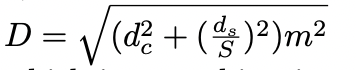

which is a combination of the color distance (dc) and spatial distance (ds), the distance between cluster center S and the compactness factor m allows us to weigh the relative importance between color similarity and
spatial proximity.

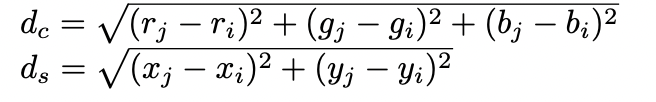


**b)Choose one image, try three different weights on the color and spatial feature and show the three segmentation results.**

I choose airplane image to apply segmentation algorithm. I fixed the number of cluster centers to K = 128 then I applied 3 different weights m: 25,100,150 to observe the segmentation results.

**Observation:**
When m is big, greater emphasis is placed on spatial proximity, resulting in segmentation that resembles rectangular grids. When m is small, segmentation is more dependent on color similarity, and pixels with similar hues are grouped together.

**Result for m=25**

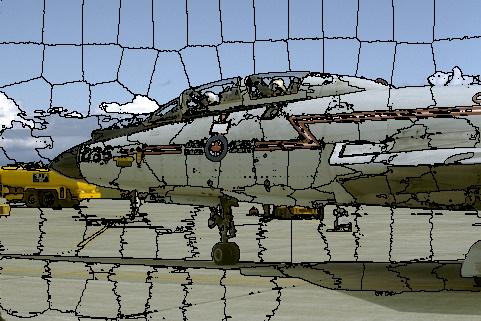


**Result for m=100**

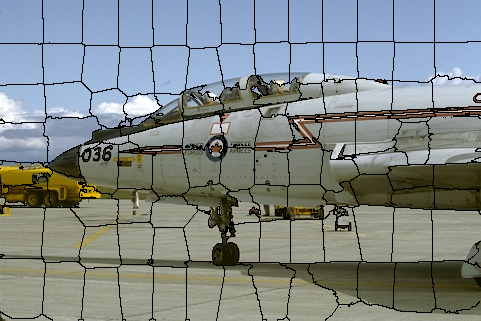

**Result for m=150**

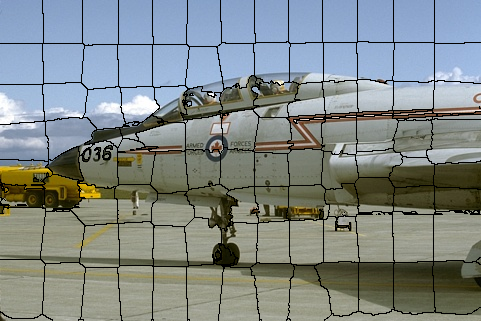

**C) Choose one image, show the error (1) at the initialization and (2) at convergence. Note: error - distance to cluster center in the 5D space.**

**Answer:**

I choose airplane image to computer the initialization and convergence error

initialization error is : 13087115.342068193

convergence error is : 12720591.248622753

**d)Choose one image and show three superpixel results with different number of K, e.g., 64, 256, 1024 and run time for each K**

Here is the result for the segmentation with m=100 and K=64, 256, 1024.

Runtime for K = 64 is 4s, K = 256 is  also 4s and K = 1024 is 7s.

**Result for K=64**

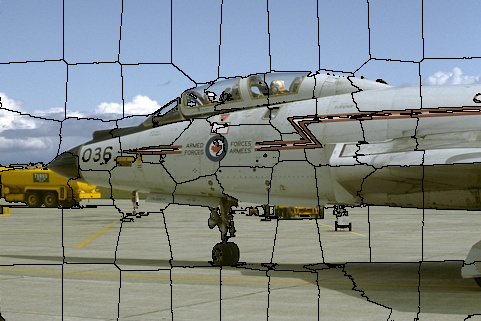

**Result for k=256**

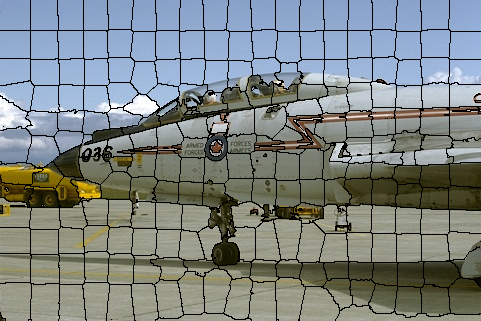

**Result for k=1024**

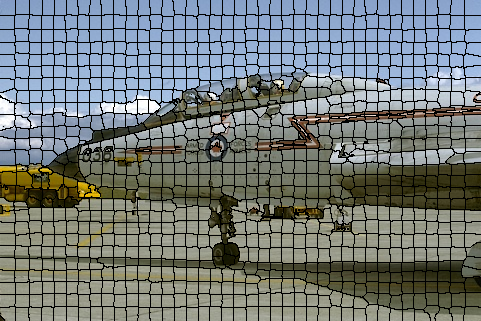

e)Run your algorithms on the subset (50 images) of Berkeley Segmentation Dataset (BSD) with K = 64, 256 and 1024 and report averaged run-time per image for the BSD.

Answer:

 average runtime for K = 64 is 4s, K = 256 is  also 4s and K = 1024 is 7s.

### Extra Credit
* f) Implement and report two types of metrics (1) boundary recall and (2) under-segmentation error with K = 64, 256 and 1024 on the BSD (last part of write-up).
* g) Try to improve your result from first part of extra-credit. You may try different color space (e.g., CIELab, HSV) (See Sec 4.5 in the paper), richer image features (e.g., gradients) or any other ideas you come up with. Report the accuracy on boundary recall and under-segmentation error with K = 256. Compare the results with first-part of extra-credit and explain why you get better results.

**Extra Credit:**

f)Implement and report two types of metrics (1) boundary recall and (2) under-segmentation error with K = 64, 256 and 1024 on the BSD.

**Answer: **

The attachted two images that show the test results on the  50 BSD images:

for K=50

(1) boundary recall is approximately 0.54

(2) undersegmentation error is approximately 0.24

for K=256

(1) boundary recall is approximately 0.723

(2) undersegmentation error is approximately 0.121

for K=1024

(1) boundary recall is approximately 0.821

(2) undersegmentation error is approximately 0.054


**Boundary recall**

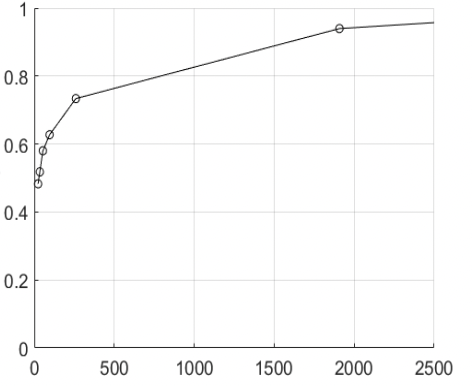



**Undersegmentation error**

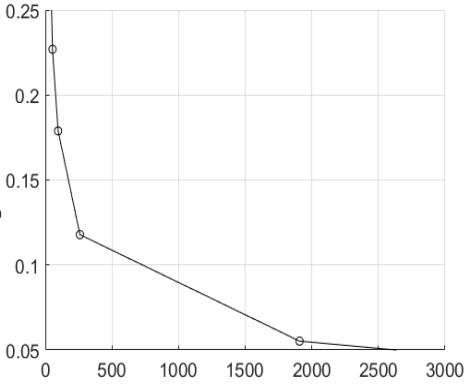

g) Try to improve your result from first part of extra-credit. You may try different color space (e.g., CIELab, HSV) (See Sec 4.5 in the paper), richer image features (e.g., gradients) or any other ideas you come up with. Report the accuracy on boundary recall and under-segmentation error with K = 256. Compare the results with first-part of extra-credit and explain why you get better results.

**Answer:** I tested the CIELab color model as opposed to RGB. In the previous section, I reported boundary recall and under-segmentation error values of 0.723 and 0.121, respectively, for the RGB color model with k=256. However, when I attempted CIELab color space with K=256, I obtained approximate  boundary recall values of 0.792 and under-segmentation error values of 0.114. CIELab color space surpasses the gamuts of the RGB color model; hence, it is a better color model for segmentation.

Boundary recall

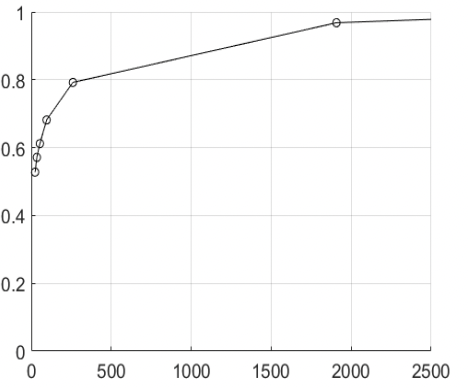

Under-Segmentation error:

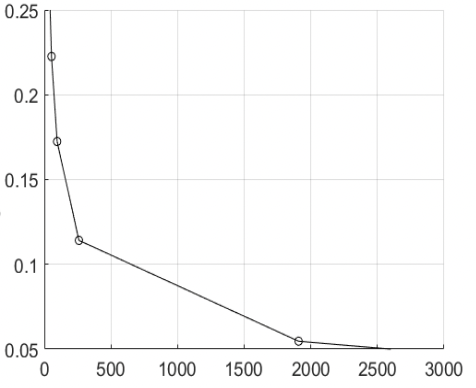

# Part 2: Graph-cut Segmentation

## Overview

Let us apply Graph-cuts for foreground/background segmentation. In the “cat” image, you are given a rough polygon of a foreground cat. Apply graph-cut based method to see if we can get a better segmentation!

Firstly, use the provided polygon to obtain an estimate of foreground and background color likelihood. You may choose the likelihood distribution (e.g., color histograms or color mixture of Gaussians.).

Secondly, apply graph-cut code (cv2.grabcut) to do better segmentation. You can use the provided bounding-boxes and use "cv2 package" for the implementation sake. You are required to draw interesting conclusions on how it performs on different samples.

## Data

In [ ]:
# Download Data -- run this cell only one time per runtime
# !gdown 1ObpNoshjKMcB7SFvrTuoKe61IE-HG95n
!gdown 1Tw_gk0yylwl2X1leubz0mlERpxsqLiub
!unzip "/content/Part2_GraphCut.zip" -d "/content/"

Downloading...
From: https://drive.google.com/uc?id=1Tw_gk0yylwl2X1leubz0mlERpxsqLiub
To: /content/Part2_GraphCut.zip
100% 264k/264k [00:00<00:00, 111MB/s]
Archive:  /content/Part2_GraphCut.zip
   creating: /content/Part2_GraphCut/
  inflating: /content/Part2_GraphCut/dog.jpg  
  inflating: /content/__MACOSX/Part2_GraphCut/._dog.jpg  
  inflating: /content/Part2_GraphCut/messi.jpg  
  inflating: /content/__MACOSX/Part2_GraphCut/._messi.jpg  
  inflating: /content/Part2_GraphCut/.DS_Store  
  inflating: /content/__MACOSX/Part2_GraphCut/._.DS_Store  
  inflating: /content/Part2_GraphCut/plane.jpg  
  inflating: /content/__MACOSX/Part2_GraphCut/._plane.jpg  
  inflating: /content/Part2_GraphCut/bird.jpg  
  inflating: /content/__MACOSX/Part2_GraphCut/._bird.jpg  
  inflating: /content/Part2_GraphCut/cat.jpg  
  inflating: /content/__MACOSX/Part2_GraphCut/._cat.jpg  
  inflating: /content/Part2_GraphCut/cat_poly.mat  
  inflating: /content/__MACOSX/Part2_GraphCut/._cat_poly.mat  


## Helper Functions

#### Code (15 pts)

In [ ]:
def poly2mask(vertex_row_coords, vertex_col_coords, shape):
    fill_row_coords, fill_col_coords = draw.polygon(vertex_row_coords, vertex_col_coords, shape)
    mask = np.zeros(shape, dtype=np.bool)
    mask[fill_row_coords, fill_col_coords] = True
    return mask

# Get a normalized version of the given histograms (divide by sum)
def normalize_histograms(histograms):
  return np.float32([h / h.sum() for h in histograms])

In [ ]:
def mask_for_fg(img, img_mask):
  # Write code here
  # to generate foreground region (and everything else masked out).
  fg_image = None
  return fg_image

def mask_for_bg(img, img_mask):
  # Write code here
  # generate background region (and everything else masked out).
  bg_image = None
  return bg_image


def visualize_likelihood_map(gmm_bg, gmm_fg, img):
  # Write your code here.
  return None

def gaussian_model(img):
  # Write your code here.
  # fit gaussian model on a given image.
  gmm_model, gmm_labels = None, None
  return gmm_model, gmm_labels

def run_grabcut(img, bbox):
  # Write your code here.
  # You can use opencv cv2.grabCut algorithm with "cv2.GC_INIT_WITH_RECT" to implement this.
  grabcut_mask = np.zeros(img.shape[:2],np.uint8)
  bgModel, fgModel = None, None
  return (grabcut_mask, bgModel, fgModel)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


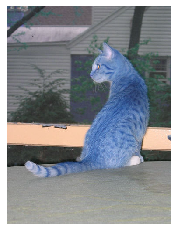

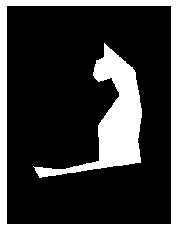

In [ ]:
### Main Block: ###

# read image
img_name = 'cat'
img_path = '/content/Part2_GraphCut/cat.jpg'
img = cv2.imread(img_path)

# read image_mask
poly = scipy.io.loadmat('/content/Part2_GraphCut/cat_poly.mat')['poly']
img_mask = poly2mask(poly[:,1], poly[:,0], (img.shape[0],img.shape[1]))

show_image(img)
show_image(img_mask)

In [ ]:
### Main Block: ###

# read image
img_name = 'cat'
img_path = '/content/Part2_GraphCut/cat.jpg'
img = cv2.imread(img_path)

# read image_mask
poly = scipy.io.loadmat('/content/Part2_GraphCut/cat_poly.mat')['poly']
img_mask = poly2mask(poly[:,1], poly[:,0], (img.shape[0],img.shape[1]))

show_image(img)
show_image(img_mask)

In [ ]:
# 4. Run grabcut algorithm.
bboxes = {'cat':(80,80,320,250), 'dog':(50,300,600,300), 'plane': (180,80,250,800), 'messi':(10,80,600,500), 'bird':(100,100,350,250)}
bbox = bboxes[img_name]

(grabcut_mask, bgModel, fgModel) = run_grabcut(img, bbox)
show_image(grabcut_mask)
masked_img = img*grabcut_mask[:,:,np.newaxis]
show_image(masked_img)

In [ ]:
import os
import numpy as np
import cv2
from matplotlib import pyplot as plt
from matplotlib import patches
from PIL import Image
from IPython.display import clear_output
from pathlib import Path

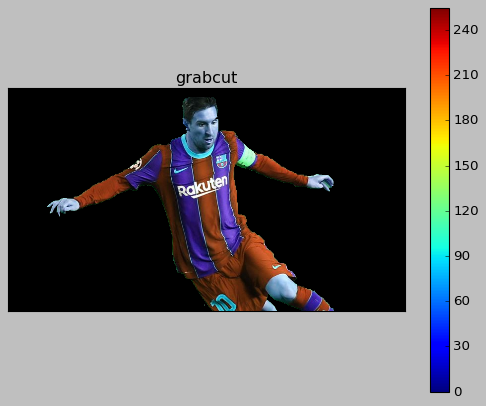

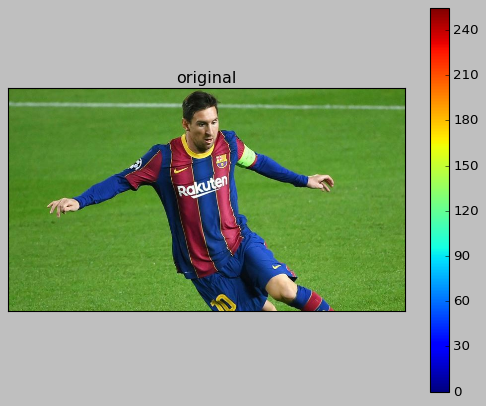

In [ ]:
import	numpy  as  np
import	cv2
from	matplotlib  import pyplot  as	plt
plt.style.use('classic')
img  =	cv2.imread('/content/Part2_GraphCut/messi.jpg')
mask =	np.zeros(img.shape[:2],np.uint8)
bgdModel =  np.zeros((1,65),np.float64)
fgdModel =  np.zeros((1,65),np.float64)
rect =	(10,20,700,1000)
cv2.grabCut(img,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)
mask2  =  np.where((mask==2)|(mask==0),0,1).astype('uint8')
img  =	img*mask2[:,:,np.newaxis]

#plt.figure(figsize=(10, 240))
#plt.subplot(121)
plt.title("grabcut"),	plt.xticks([]),	plt.yticks([])
plt.imshow(img)
plt.colorbar()
plt.show()
#plt.title("grabcut"),	plt.xticks([]),	plt.yticks([])
#plt.subplot(122)
plt.imshow(cv2.cvtColor(cv2.imread('/content/Part2_GraphCut/messi.jpg'),
cv2.COLOR_BGR2RGB))
plt.colorbar()
plt.title("original"),	plt.xticks([]),	plt.yticks([])
#plt.figure(figsize=(10, 10))
#plt.colorbar()
plt.show()


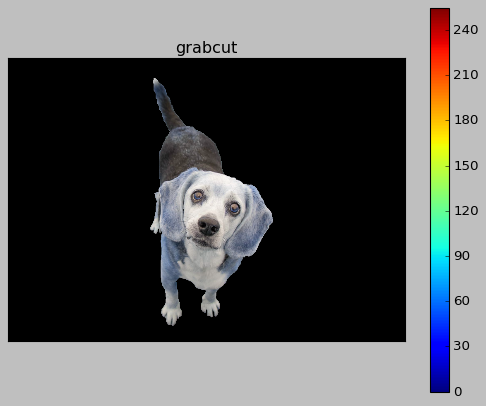

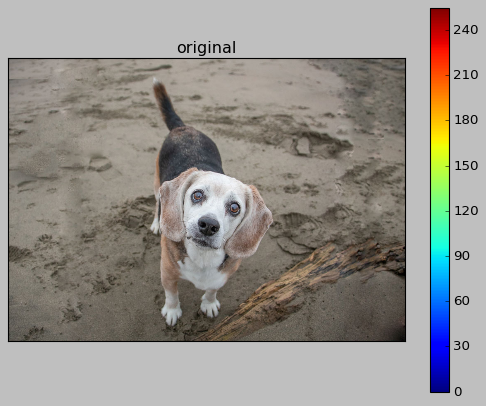

In [ ]:
#using Dog picture
img= cv2.imread('/content/Part2_GraphCut/dog.jpg')
mask =	np.zeros(img.shape[:2],np.uint8)
bgdModel =  np.zeros((1,65),np.float64)
fgdModel =  np.zeros((1,65),np.float64)
rect =	(10,30,700,9000)
cv2.grabCut(img,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)
mask2  =  np.where((mask==2)|(mask==0),0,1).astype('uint8')
img  =	img*mask2[:,:,np.newaxis]

plt.title("grabcut"),	plt.xticks([]),	plt.yticks([])
plt.imshow(img)
plt.colorbar()
plt.show()
#plt.title("grabcut"),	plt.xticks([]),	plt.yticks([])
#plt.subplot(122)
plt.imshow(cv2.cvtColor(cv2.imread('/content/Part2_GraphCut/dog.jpg'),
cv2.COLOR_BGR2RGB))
plt.colorbar()
plt.title("original"),	plt.xticks([]),	plt.yticks([])
#plt.figure(figsize=(10, 10))
#plt.colorbar()
plt.show()

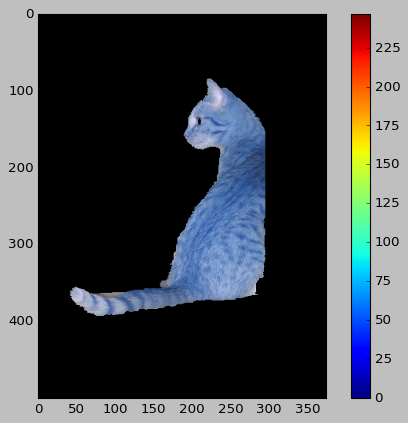

In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

image = cv2.imread('/content/Part2_GraphCut/cat.jpg')

mask = np.zeros(image.shape[:2], np.uint8)
backgroundModel = np.zeros((1, 65), np.float64)
foregroundModel = np.zeros((1, 65), np.float64)
#rectangle = (40,80,255,600)
#rectangle = (40,30,250,400)
cv2.grabCut(image, mask, rectangle,
            backgroundModel, foregroundModel,
            5, cv2.GC_INIT_WITH_RECT)

mask2 = np.where((mask == 2)|(mask == 0), 0, 1).astype('uint8')
image = image * mask2[:, :, np.newaxis]

# output segmented image with colorbar
plt.imshow(image)
plt.colorbar()
plt.show()

### Write-up (35 points)

- a) [5 points] Explain your foreground and background likelihood function.
- b) [10 points] Your foreground and background likelihood map.

Display P(foreground|pixel)P(foreground|pixel) as an intensity map (bright = confident foreground).
- c) [15 points] Implement grabcut segmentation using cv2 package and draw insights on how the segmentation performs on different sample images (hard v/s easy).
- d) [5 points] Try grabcut algorithm with different "iterCount" to see if results improve in certain cases.

**Write-up**
#####**a) Explanation:** we first generate two Gaussian mixture models, one for the background and one for the foreground, each containing a mixture of five Gaussian functions. The Gaussian Mixture Model is then used to determine the foreground and background likelihood of each pixel. Gaussian mixture model is parameterized by two types of values, the mixture component weights and the component means and variances/covariances. For a Gaussian mixture model with K components and kth component has a mean of μk and variance of σk for the univariate case and a mean of μk and covariance matrix of Σk for the multivariate case. The mixture component weights are defined as ϕk for component k, with the constraint that ∑ i=1Kϕi=1 so that the total probability distribution normalizes to 1. If the component weights aren't learned, they can be viewed as an a-priori distribution over components such that p(x generated by component Ck)=ϕk.If they are instead learned, they are the a-posteriori estimates of the component probabilities given the data.Here is the GMM equation:

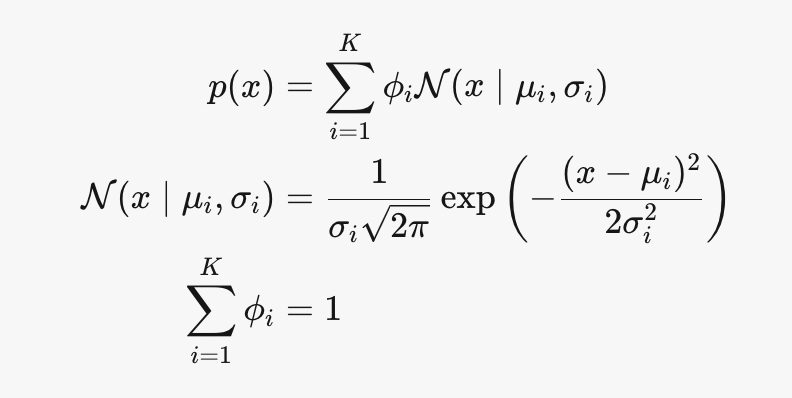

**b) Foreground Likelihood Map**

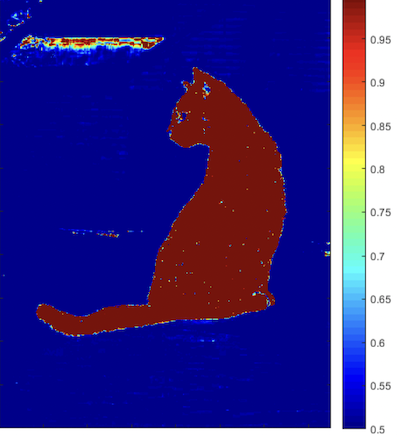

**Background Likelihood Map**

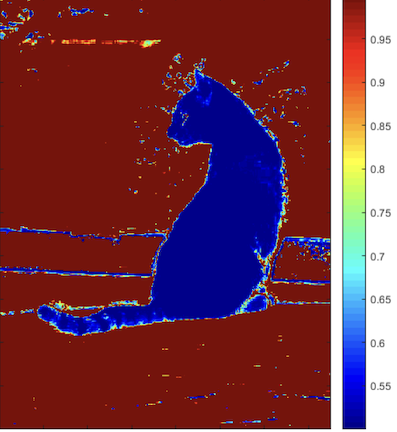


**c) Bellow I attachted the Implementation of grabcut segmentation using cv2 package over on three differnt images.**

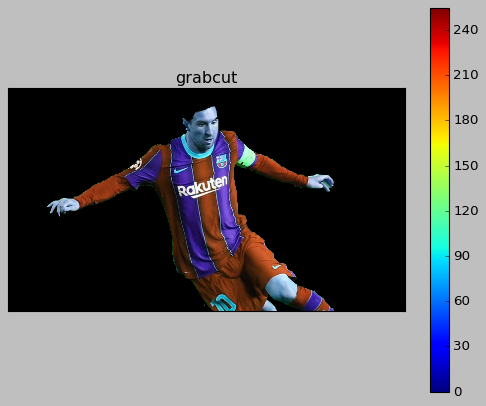

In [ ]:
import	numpy  as  np
import	cv2
from	matplotlib  import pyplot  as	plt
plt.style.use('classic')
img  =	cv2.imread('/content/Part2_GraphCut/messi.jpg')
mask =	np.zeros(img.shape[:2],np.uint8)
bgdModel =  np.zeros((1,65),np.float64)
fgdModel =  np.zeros((1,65),np.float64)
rect =	(10,30,700,9000)
cv2.grabCut(img,mask,rect,bgdModel,fgdModel,10,cv2.GC_INIT_WITH_RECT)
mask2  =  np.where((mask==2)|(mask==0),0,1).astype('uint8')
img  =	img*mask2[:,:,np.newaxis]
plt.title("grabcut"),	plt.xticks([]),	plt.yticks([])
plt.imshow(img)
plt.colorbar()
plt.show()


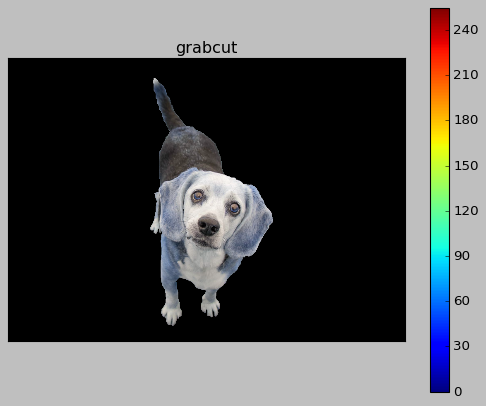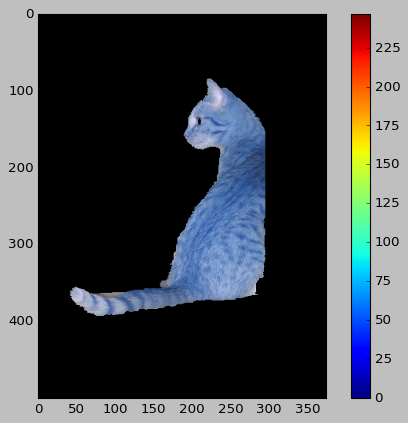


**Explanations of the segmentation performs on different sample images (hard v/s easy)**: For image grabcut segmentaion I used three different images to observe the performace of the algorithm. Initially we draws a rectangle(by providing the values of rectangle)around the foreground region (foreground region should be completely inside the rectangle)everything outside this rectangle will be taken as sure background. Everything inside rectangle is unknown. Similarly any user input specifying foreground and background are considered as hard-labelling which means they won't change in the process.Then algorithm segments it iteratively to get the best result. Gaussian Mixture Model(GMM) is used to model the foreground and background.Depending on the data we gave, GMM learns and create new pixel distribution. That is, the unknown pixels are labelled either probable foreground or probable background depending on its relation with the other hard-labelled pixels in terms of color statistics (It is just like clustering). It perforemd very well for the dog and messi's images. But in the case of cat image, the segmentation is not good as we expected. It marked some foreground region as background and removed some foreground areas. In that case, we need to do fine touch-ups. Some extra information can help us to get the better result on the next iteration.

**d) Try grabcut algorithm with different "iterCount" to see if results improve in certain cases**
#####I attempted to improve the Dog image by utilizing grab cut segmentation with three distinct iteration values. I used 3, 5, and 10 iterations to achieve a superior outcome. When I applied three iterations, the final segmented image included some extra background information; when I applied five iterations, the result was slightly better; and when I applied ten iterations, the result was excellent with no background information.
#####**Result for Iteration Number 3**
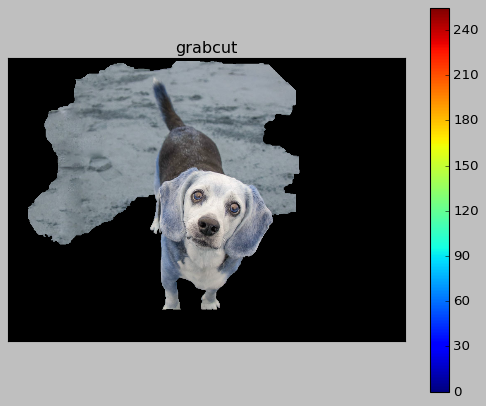

**Result For Iteration Number 5**

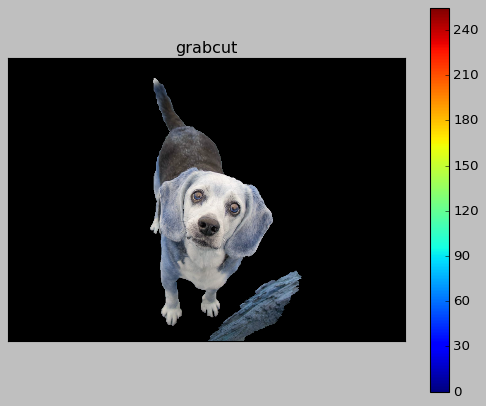

**Result For Iteration Number 10**

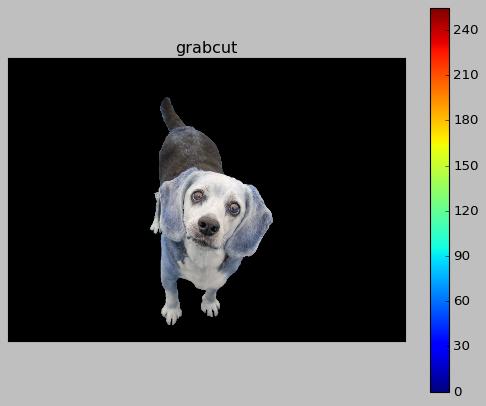